In [1]:
from scipy.io import loadmat
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import json

from smooth import smoothen


%matplotlib inline

In [2]:
filelist = ["calcium_data/140708B_140811a_result", 
            "calcium_data/140909C_141112a_result", 
            "calcium_data/141006C_141121a_result",
            "calcium_data/150109A_150302a_result", 
            "calcium_data/151122A_160202a_result", 
            "calcium_data/151122B_160207a_result", 
            "calcium_data/160209A_160430a_result", 
            "calcium_data/160209B_160428a_result"]

experiemntal parameters:

v(0): hit/miss, +1 for hit, -1 for miss

v(1): stimulus intensity

v(2): rest of variance

In [3]:
def cumsum_plus(data, tau=0.9):
    res = np.zeros((data.shape[0], data.shape[1], data.shape[2]))
    res[:,:,0] = data[:,:,0]
    for t in range(data.shape[2]-1):
        res[:,:,t+1] = tau*res[:,:,t] + data[:,:,t+1]
        
    return res

In [4]:
def preprocessing(filename, time='full', windows=None, z_score=True, smooth=True, bl=True, leak=None, csum=True):
    '''
    Preprocesses the data according to specified parameters
    
    filename: string, specifies file to use. If None, concatenate all files
    time: string
        'full' - use full time series of the dendritic Ca2+ signal
        'windowed' - use only one point per dendrite, averaged over specified window
    windows: ndarray, 7x2 or n_filesx7x2. 
        Required in windowed mode. Array holds start- and stop times for each stimulus.
    z_score: bool, whether to z-score the data. 
    '''
    
    assert(not(time=='windowed') or not(windows == None))
    
    #get the data we need into the format we need
    if type(filename) == list:
        #create concatenated data, prompt if file already exitsts
        #in this case, other experiments are interpreted as different units, but same trials as
        #other units. Not all experiments have same units, and not same stimuli, so...later.
        try:
            f = h5py.File('allexp.hdf5', 'w-')
        except OSError:
            print('file already exists, type "continue" to overwrite \n')
            if input() == 'continue':
                f = h5py.File('allexp.hdf5', 'w')
                
        #filename denotes a list of files in this case
        for file in filename:
            #finish later, or probably not
            pass
    else:
        #just load data from specified file
        f = h5py.File(filename+'.hdf5', 'r')
        g = h5py.File(filename[:-6]+"roi.hdf5", "r")
        motion_mask = (g['inFrameDend'][:].astype(bool)).reshape(g['inFrameDend'].shape[0])
        
        data = f['data'][:, motion_mask, :]
        meta = f['meta']
        
    baseline = np.mean(data[:,:,:58], axis=2).reshape(data.shape[0], data.shape[1], 1)
    if bl:
        data = data - baseline
    
    if time == 'full':
        if smooth:
            #if we smoothen the data
            if not leak:
                if csum:
                    data_pass = np.cumsum(smoothen(filename)[:,motion_mask,:], axis=2)
                else:
                    data_pass = smoothen(filename)[:,motion_mask,:]
            else:
                if csum:
                    data_pass = cumsum_plus(smoothen(filename)[:,motion_mask,:], tau=leak)
                else:
                    print('Bad options')
        else:
            #keep all times
            if not leak:
                data_pass = np.cumsum(data[:], axis=2)
            else:
                data_pass = cumsum_plus(data[:], tau=leak)
        meta_pass = meta[:]
        
    if time == 'windowed':
        #get window-averaged
        meta_pass = meta[:]
        data_pass = np.zeros((data.shape[0], data.shape[1]))
        
        stims = np.unique(meta[:,1])
        for i, amp in enumerate(stims):
            amp_mask = meta[:,1] == amp
            data_pass[amp_mask] = np.mean(data[amp_mask,:,windows[i,0], windows[i,1]], axis=2)
            
    if z_score:
        #z_score signal
        mns = np.mean(data_pass, axis=0)
        try:
        #specify exception
            mns = np.mean(mns, axis=1)
        except:
            print('Exception triggered')
            
        try:
            stds = np.std(data_pass, axis=(0,2))
        except:
            print('Exception triggered')
            
        mns = np.transpose(np.tile(mns, (data.shape[0], data.shape[2], 1)), axes=[0,2,1])
        stds = np.transpose(np.tile(stds, (data.shape[0], data.shape[2], 1)), axes=[0,2,1])
        
        data_pass = data_pass - mns
        data_pass = data_pass/stds
            
    #possibly add functionality for subtracting mean, but not dividing by std.
    return meta_pass, data_pass

In [5]:
def get_betas(meta, data):
    n_trials = data.shape[0]
    n_units = data.shape[1]
    n_times = data.shape[2]
    
    F_i = np.ones((3, n_trials))
    F_i[0, :] = meta[:, 2]
    F_i[1, :] = meta[:, 1]
    
    #tensor math more efficient?
    beta = np.zeros((n_units, n_times, 3))
    F_fac = np.dot(np.linalg.inv(np.dot(F_i, F_i.T)), F_i)
    
    for i in range(n_units):
        for t in range(n_times):
            r_it = data[:,i,t]
            beta[i, t, :] = F_fac.dot(r_it)
            
    return beta

In [6]:
def get_population_response(meta, data):
    '''
    returns ndarray of shape conditions x times x units
    '''
    n_units = data.shape[1]
    n_trials = data.shape[0]
    n_times = data.shape[2]
    
    stims = np.unique(meta[:,1])
    n_stims = stims.shape[0]
    
    #get mask for hit- and miss conditions
    hit_mask = meta[:, 2] == 1
    miss_mask = meta[:, 2] == 0
    
    hit_stim_masks = []
    miss_stim_masks = []
    
    #get masks for all stimulus conditions
    for stim in stims:
        stim_mask = meta[:, 1] == stim
        hit_stim_masks.append(np.logical_and(stim_mask, hit_mask))
        miss_stim_masks.append(np.logical_and(stim_mask, miss_mask))
        
    n_conditions = len(hit_stim_masks) + len(miss_stim_masks)

    x = np.zeros((n_conditions, n_times, n_units))
    #CONVENTION: all hit, then all miss
    
    for i in range(n_conditions):
        if i < len(hit_stim_masks):
            x[i, :, :] = np.mean(data[hit_stim_masks[i]], axis=0).T
        else:
            j = i%len(hit_stim_masks)
            x[i, :, :] = np.mean(data[miss_stim_masks[j]], axis=0).T
            
    return x

In [7]:
def build_X_PCA(meta, data):    
    x = get_population_response(meta, data)
    n_conds = x.shape[0]
    n_times = x.shape[1]
    n_dends = x.shape[2]
    
    X = x.reshape((n_conds*n_times, n_dends))
    
    return X

In [8]:
def scree(X):
    pca = PCA()
    pca.fit(X)
    
    return pca

In [9]:
def do_PCA(X, n_comps=12):
    pca = PCA(n_components=12)
    
    #denoising, but staying in original space!
    X_pca = pca.fit_transform(X)
    
    return pca.inverse_transform(X_pca), pca

In [10]:
def get_beta_pca(beta_re, pca):
    beta_pca = np.zeros((beta_re.shape[0], beta_re.shape[1], beta_re.shape[2]))
    for i in range(beta.shape[2]):
        beta_pca[i,:,:] = pca.inverse_transform(pca.transform(beta_re[i,:,:]))
    return beta_pca

In [11]:
def get_beta_max(beta_pca):
    beta_norms = np.linalg.norm(beta_pca, axis=2)
    t_max = np.argmax(beta_norms, axis=1)
    beta_max = np.zeros((beta_pca.shape[0], beta_pca.shape[2]))

    for i, t in enumerate(t_max):
        beta_max[i,:] = beta_pca[i, t, :]
    
    print('max times: \n choice: {} ms \n intensity: {} ms'.format(t_max[0]*17, t_max[1]*17))
    return beta_max

In [12]:
def filter_c(meta, data, hit, stim_id):
    n_trials = data.shape[0]
    
    if hit == None:
        hit_mask = np.ones(n_trials) == np.ones(n_trials)
    if hit == 1:
        hit_mask = meta[:,2] == 1
    if hit == 0:
        hit_mask = meta[:,2] == 0
        
    stims = np.unique(meta[:,1])
    
    stim_mask = meta[:,1] == stims[stim_id]
    
    trials_mask = np.logical_and(hit_mask, stim_mask)
    
    return data[trials_mask]

In [90]:
meta, data = preprocessing(filelist[2], time='full', windows=None, z_score=True, smooth=True, bl=True, leak=None, csum=True)

In [91]:
beta = get_betas(meta, data)
beta_re = np.transpose(beta, axes=(2,1,0))

In [92]:
x = get_population_response(meta, data)

In [93]:
X = build_X_PCA(meta, data)

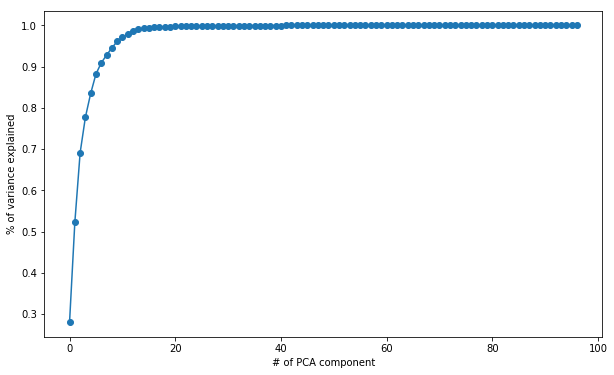

In [94]:
pca = scree(X)

plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('# of PCA component')
plt.ylabel('% of variance explained')

In [95]:
n_comps = 12
X_pca, pca = do_PCA(X, n_comps=n_comps)

In [96]:
beta_pca = get_beta_pca(beta_re, pca)

In [97]:
beta_max = get_beta_max(beta_pca)[:2,:]

max times: 
 choice: 3043 ms 
 intensity: 3043 ms


In [98]:
a = beta_max[0,:]
b = beta_max[1,:]

np.corrcoef(beta_max)

array([[ 1.        , -0.74380527],
       [-0.74380527,  1.        ]])

In [99]:
Q, R = np.linalg.qr(beta_max.T)

In [100]:
b_1 = Q[:,0]
b_2 = Q[:,1]

In [101]:
X_ = []
for i in range(14):
    X_.append(x[i])

In [102]:
choice = []
intensity = []
for i in range(14):
    choice.append(np.dot(b_1, X_[i].T))
    intensity.append(np.dot(b_2, X_[i].T))

In [103]:
stims = np.unique(meta[:,1])

f = h5py.File(filelist[1]+'.hdf5', 'r')
licktimes = f['licktimes'][:]
f.close()

avs = []
single = []

#first 7 hits, then 7 misses
for i in range(14):
    licks = np.zeros(data.shape[2])
    if i < 7:
        hit_mask = meta[:,2] == 1
    else:
        hit_mask = meta[:,2] == 0
        
    stim = stims[i%7]
    stim_mask = meta[:,1] == stim
    
    trials_mask = np.logical_and(hit_mask, stim_mask)
    
    l_times = licktimes[trials_mask]
    
    sng = np.zeros((l_times.shape[0], data.shape[2]))
    av = np.zeros(data.shape[2])
    
    for i in range(l_times.shape[0]):
        for l in l_times[i]:
            if l > -0.5:
                t = int((l+1000)/17)
                sng[i, t] += 1
                av[t] += 1
    single.append(sng)
    avs.append(av)

/home/georg/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 315 but corresponding boolean dimension is 210


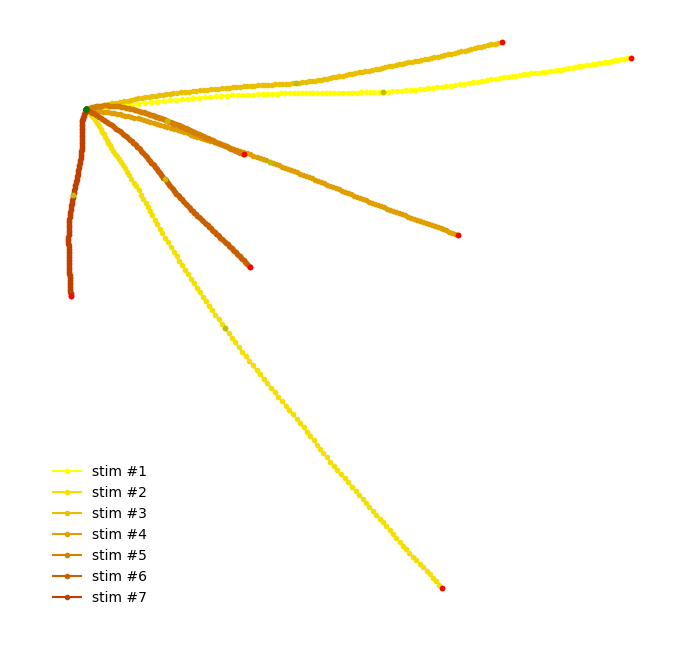

In [104]:
x_ground = choice[0][58]
y_ground = intensity[0][58]

colors = ['#BF3F00', '#CA5F00', '#D47F00', '#DF9F00', '#EABF00', '#F4DF00', '#FFFF00'][::-1]

#plt.figure(figsize=(8,8), dpi=100, frameon=False)
fig, ax = plt.subplots(figsize=(8,8), dpi=100)
ax.axis('off')
for i in range(7):
    c = i
    
    diffx = choice[i][58] - x_ground
    diffy = intensity[i][58] - y_ground
    
    plt.plot(choice[c][58:]-diffx, intensity[c][58:]-diffy, marker='o', markersize=3, color=colors[i], zorder=1, label='stim #{}'.format(i+1))
    plt.scatter(choice[c][58]-diffx, intensity[c][58]-diffy, color='g', s=10, zorder=2)
    plt.scatter(choice[c][116]-diffx, intensity[c][116]-diffy, color='y', s=10, zorder=2)
    plt.scatter(choice[c][179]-diffx, intensity[c][179]-diffy, color='r', s=10, zorder=2)
    
    plt.legend(frameon=False)

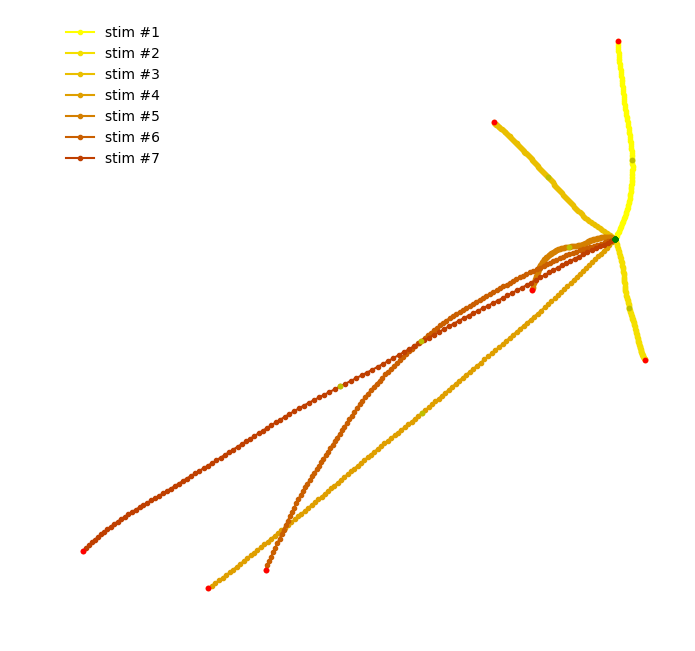

In [105]:
x_ground = choice[7][58]
y_ground = intensity[7][58]

colors = ['#BF3F00', '#CA5F00', '#D47F00', '#DF9F00', '#EABF00', '#F4DF00', '#FFFF00'][::-1]

#plt.figure(figsize=(8,8), dpi=100)
fig, ax = plt.subplots(figsize=(8,8), dpi=100)
ax.axis('off')
for i in range(7):
    i = i+7
    c = i
    
    diffx = choice[i][58] - x_ground
    diffy = intensity[i][58] - y_ground
    
    plt.plot(choice[c][58:]-diffx, intensity[c][58:]-diffy, marker='o', markersize=3, color=colors[i-7], zorder=1, label='stim #{}'.format(i-6))
    plt.scatter(choice[c][58]-diffx, intensity[c][58]-diffy, color='g', s=10, zorder=2)
    plt.scatter(choice[c][116]-diffx, intensity[c][116]-diffy, color='y', s=10, zorder=2)
    plt.scatter(choice[c][179]-diffx, intensity[c][179]-diffy, color='r', s=10, zorder=2)
    
    plt.legend(frameon=False)

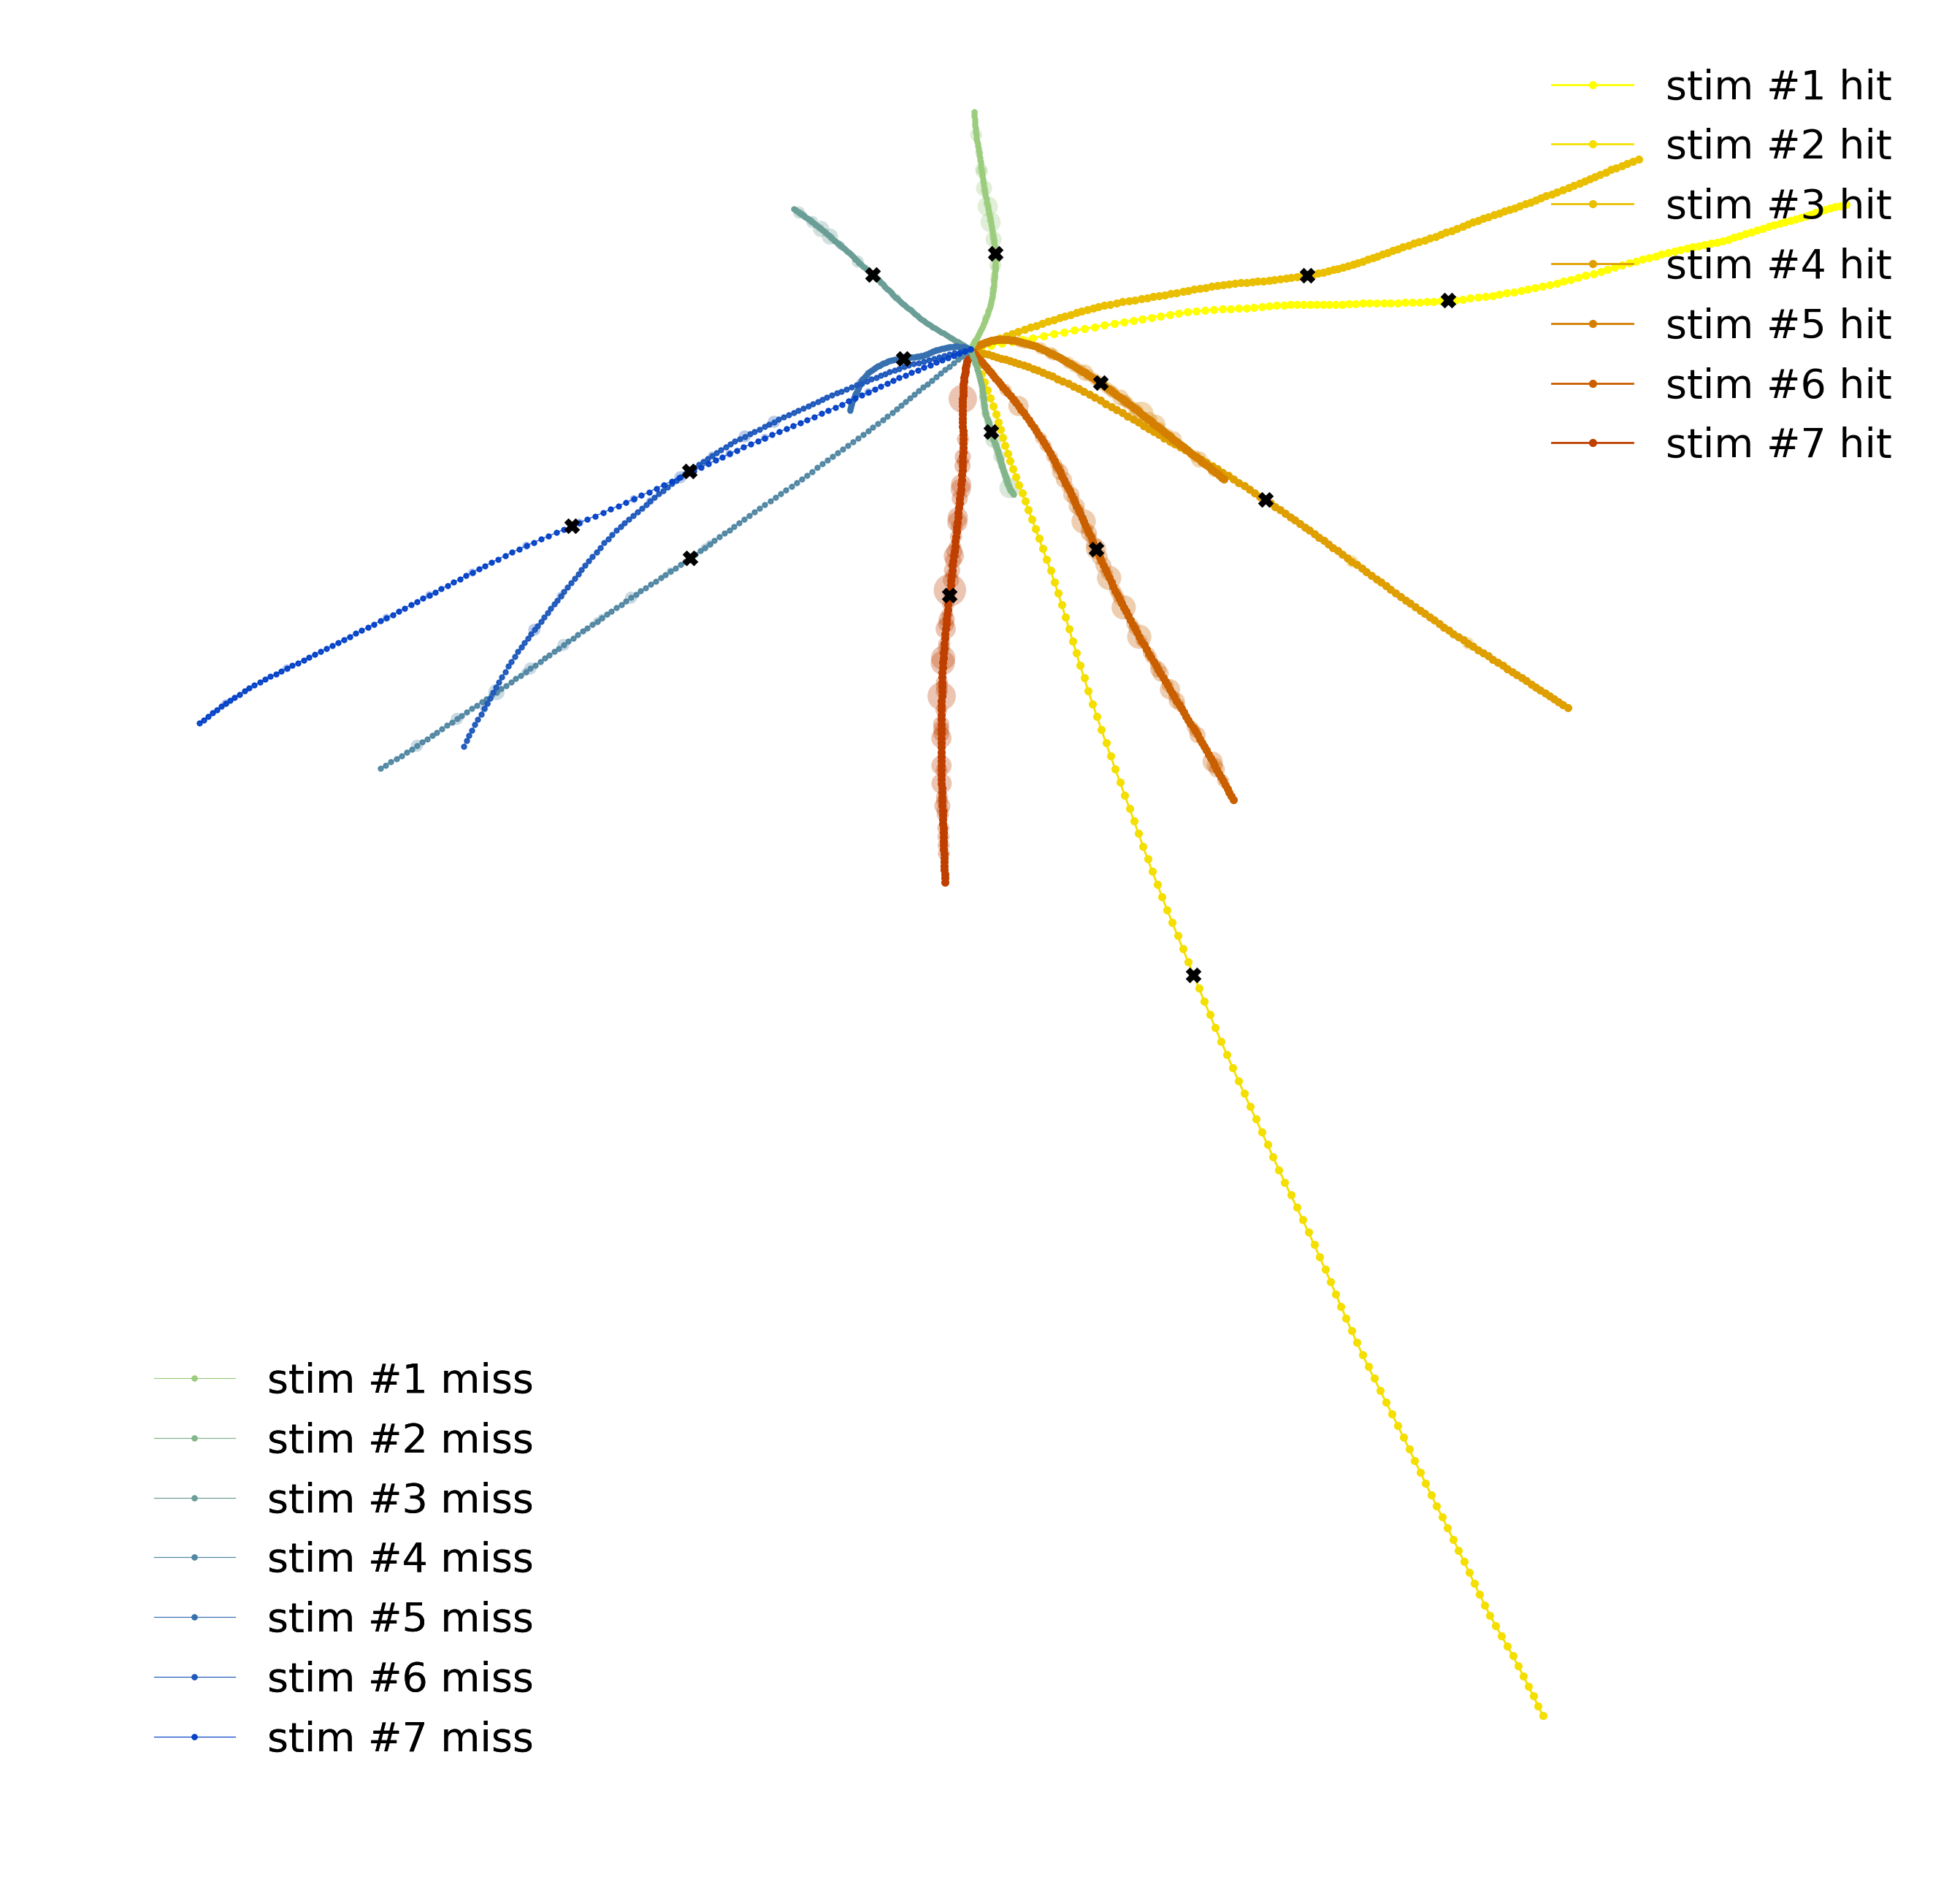

In [129]:
x_ground = choice[0][58]
y_ground = intensity[0][58]

colors = ['#BF3F00', '#CA5F00', '#D47F00', '#DF9F00', '#EABF00', '#F4DF00', '#FFFF00'][::-1]
colors_m = ['#0542C7', '#1E59BB', '#3770AF', '#5187A3', '#6A9E96', '#83B58A', '#9CCC7E'][::-1]

#plt.figure(figsize=(8,8), dpi=100, frameon=False)
fig, ax = plt.subplots(figsize=(8,8), dpi=400)
ax.axis('off')
hit_labels = []
miss_labels = []
for i in range(7):
    c = i
    d = i+7
    
    diffx = choice[i][58] - x_ground
    diffy = intensity[i][58] - y_ground
    
    diffxx = choice[i+7][58] - x_ground
    diffyy = intensity[i+7][58] - y_ground
    
    #diffx = 0
    #diffy = 0
    #diffxx = 0
    #diffyy = 0
    
    a = avs[i] != 0
    
    plt.scatter(choice[c][116]-diffx, intensity[c][116]-diffy, marker='x', zorder=4, color='black', s=8)
    plt.scatter(choice[d][116]-diffxx, intensity[d][116]-diffyy, marker='x', zorder=4, color='black', s=8)

    h, = plt.plot(choice[c][58:]-diffx, intensity[c][58:]-diffy, marker='o', linewidth=0.5, markersize=1, color=colors[i], zorder=1, label='stim #{} hit'.format(i+1))
    plt.scatter(choice[c][58:]-diffx, intensity[c][58:]-diffy, s=avs[i][58:]**2, edgecolor='none', color=colors[i], alpha=0.3, zorder=1)
    plt.scatter(choice[d][58:]-diffxx, intensity[d][58:]-diffyy, s=avs[d][58:]**2, edgecolor='none', color=colors_m[i], alpha=0.3, zorder=1)
    m, = plt.plot(choice[d][58:]-diffxx, intensity[d][58:]-diffyy, marker='o', linewidth=0.2, markersize=0.5, color=colors_m[i], zorder=2, label='stim #{} miss'.format(i+1))
    hit_labels.append('stim #{} hit'.format(i+1))
    miss_labels.append('stim #{} miss'.format(i+1))
    #plt.scatter(choice[c][58]-diffx, intensity[c][58]-diffy, color='g', s=10, zorder=2)
    #plt.scatter(choice[c][116]-diffx, intensity[c][116]-diffy, color='y', s=10, zorder=2)
    #plt.scatter(choice[c][179]-diffx, intensity[c][179]-diffy, color='r', s=10, zorder=2)
#first_legend = plt.legend(hits[0],['asd', 'as', 'a', 'a', 'a', 'a,', 'a'])
#plt.legend(hits[0] for h in hits)
#plt.gca().add_artist(first_legend)
#plt.plot(xx,yy)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0,2,4, 6, 8, 10, 12]], hit_labels, loc=1)
legend2 = plt.legend([lines[i] for i in [1,3,5, 7, 9, 11, 13]], miss_labels, loc=3)
ax.add_artist(legend1)
ax.add_artist(legend2)
legend1.set_frame_on(False)
legend2.set_frame_on(False)

In [107]:
beta_tilde = np.zeros((2, beta_pca.shape[1], beta_pca.shape[2]))
for t in range(beta_pca.shape[1]):
    beta_tilde[0, t, :] = beta_max[0]
    beta_tilde[1, t, :] = beta_pca[1, t, :]

In [108]:
Q_tot = np.zeros((beta_tilde.shape[2], beta_tilde.shape[0], beta_tilde.shape[1]))
for t in range(beta_tilde.shape[1]):
    Q_tilde, R_tilde = np.linalg.qr(beta_tilde[:,t,:].T)
    Q_tot[:,:,t] = Q_tilde

In [109]:
b_1_tilde = Q_tot[:,0,:]
b_2_tilde = Q_tot[:,1,:]

In [110]:
choice_tilde = []
intensity_tilde = []
for i in range(14):
    c_t = np.zeros(b_1_tilde.shape[1])
    i_t = np.zeros(b_1_tilde.shape[1])
    for t in range(b_1_tilde.shape[1]):
        c_t[t] = np.dot(b_1_tilde[:,t], X_[i][t].T)
        i_t[t] = np.dot(b_2_tilde[:,t], X_[i][t].T)
    choice_tilde.append(c_t)
    intensity_tilde.append(i_t)

In [111]:
i_new = np.vstack(intensity)
c_new = np.vstack(choice)
it_new = np.vstack(intensity_tilde)
ct_new = np.vstack(choice_tilde)

In [112]:
i_var = np.zeros(i_new.shape[1])
it_var = np.zeros(i_new.shape[1])
c_var = np.zeros(i_new.shape[1])
ct_var = np.zeros(i_new.shape[1])
for t in range(i_new.shape[1]):
    i_var[t] = np.var(i_new[:,t])
    c_var[t] = np.var(c_new[:,t])
    it_var[t] = np.var(it_new[:,t])
    ct_var[t] = np.var(ct_new[:,t])

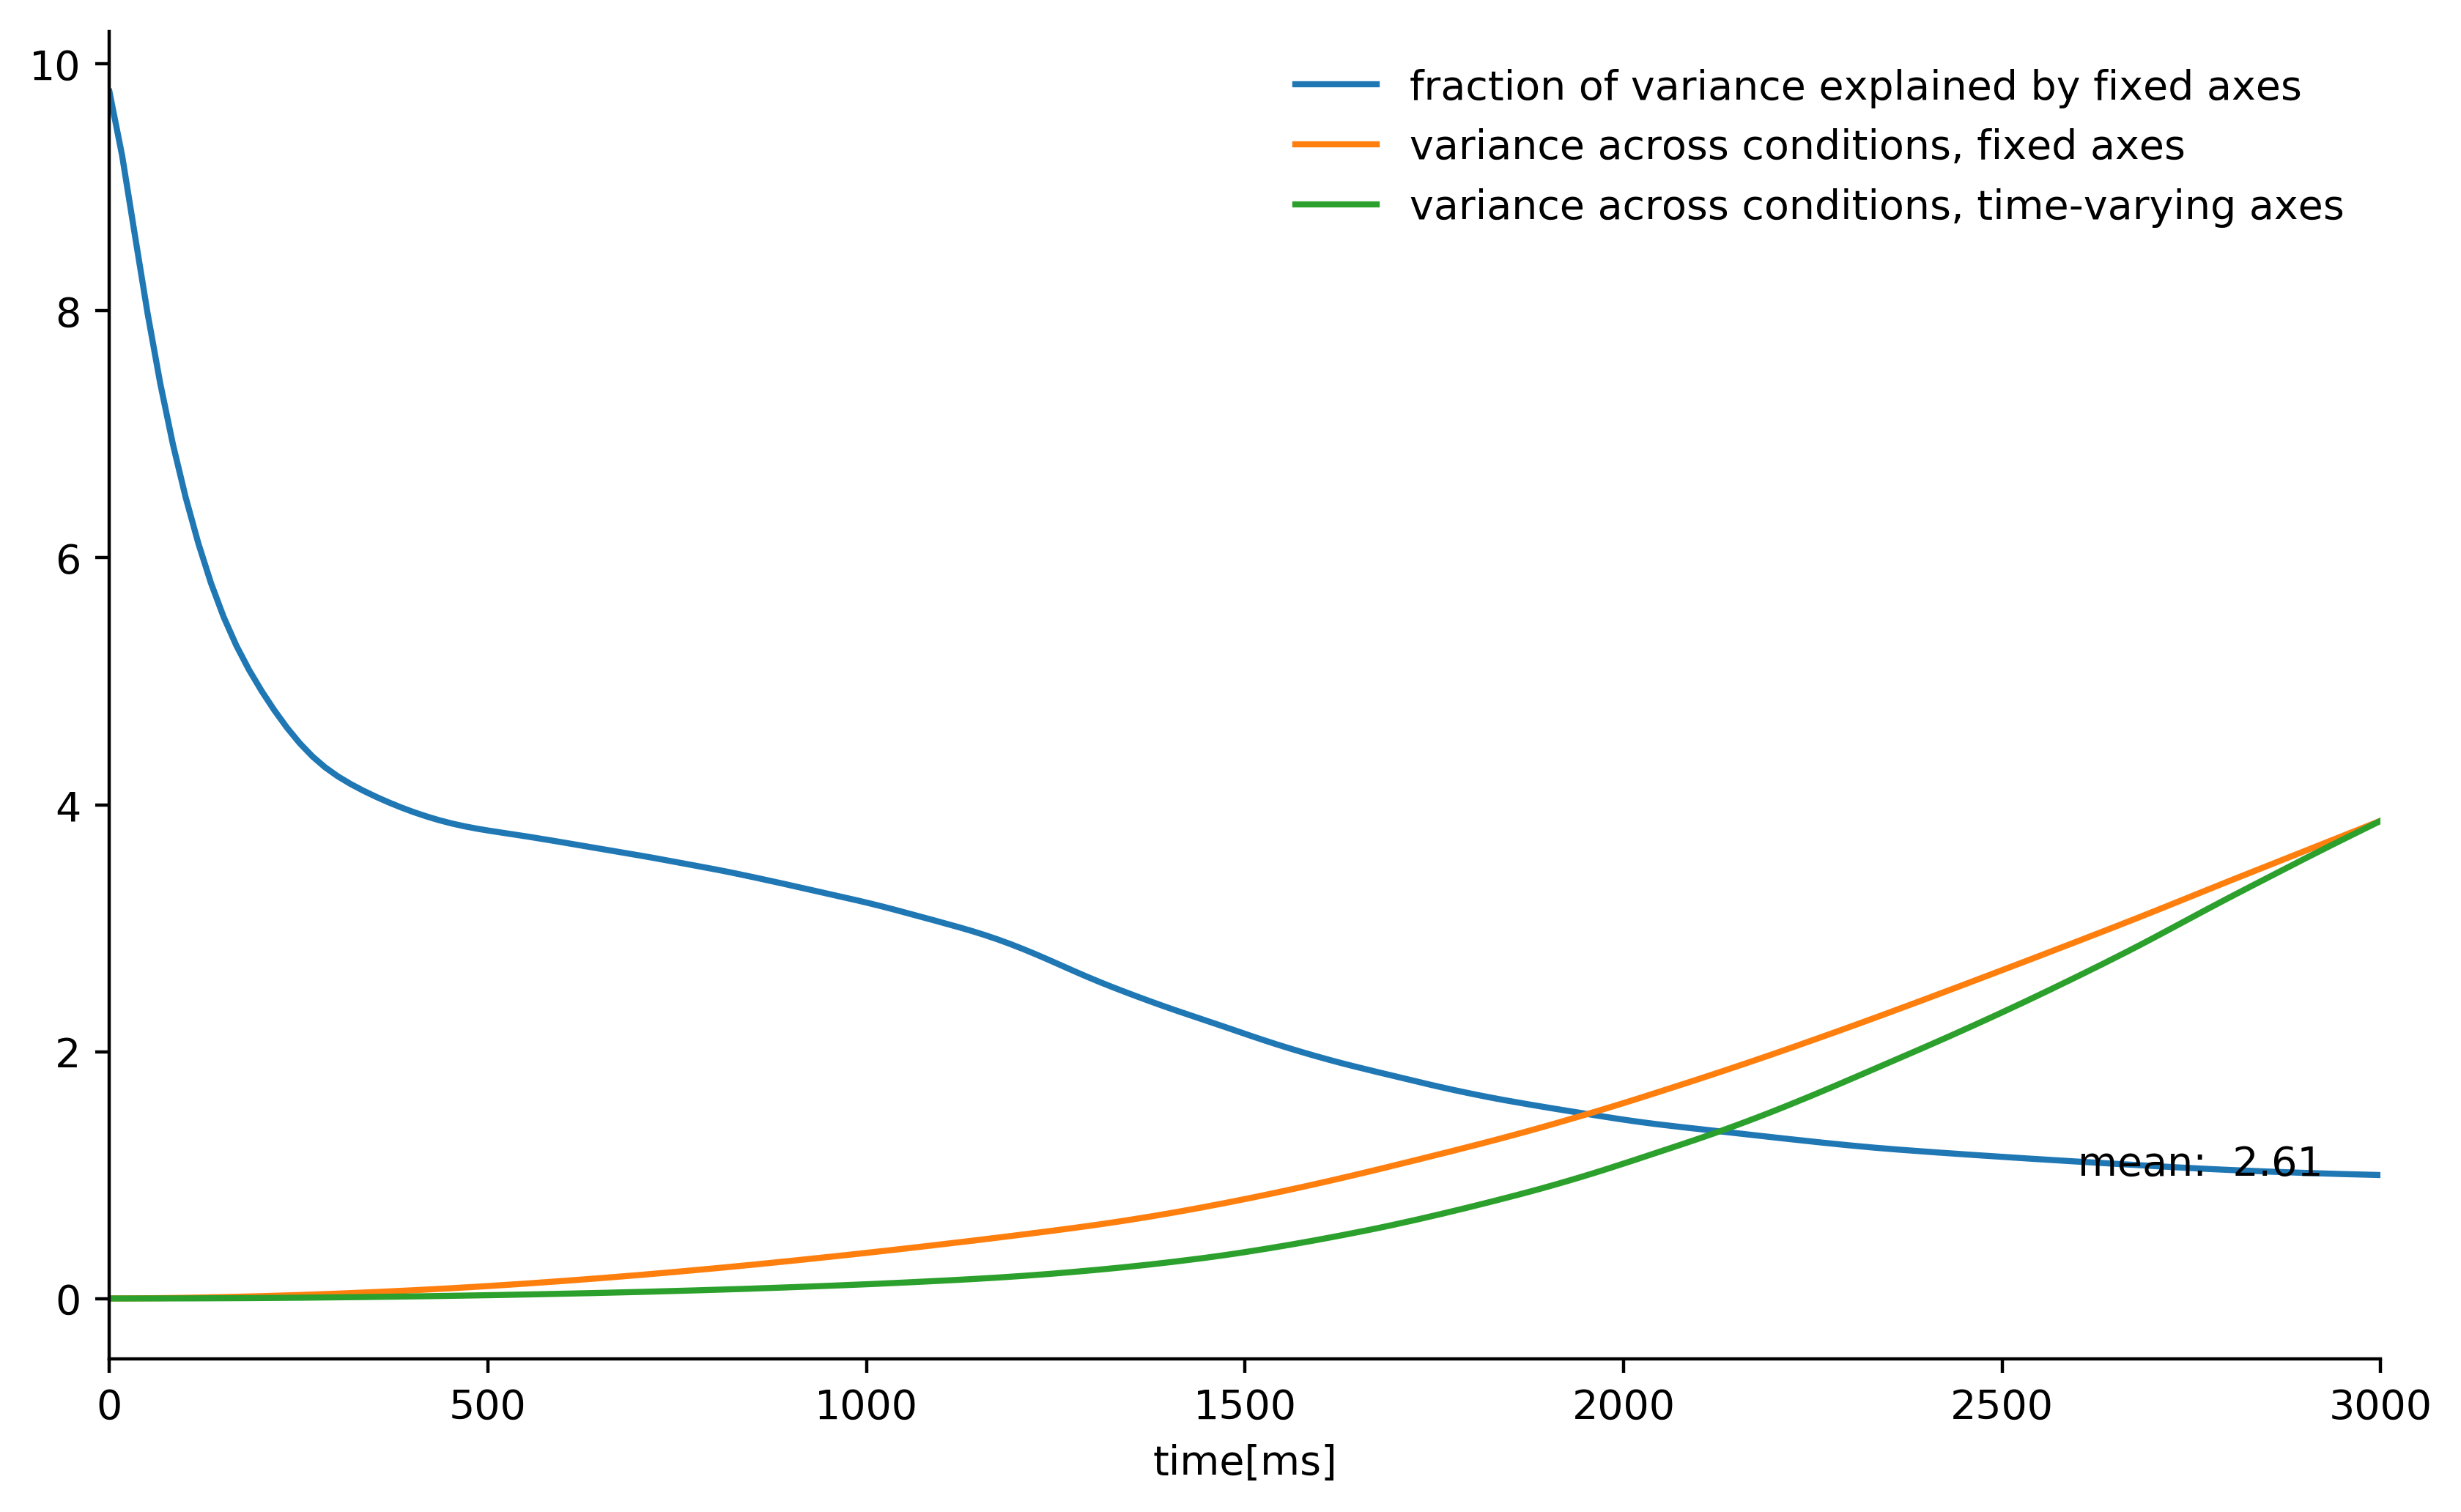

In [113]:
fig, ax = plt.subplots(figsize=(10,6), dpi=400)
ax.plot(np.linspace(0,3000, 180), i_var/it_var, label='fraction of variance explained by fixed axes')
ax.plot(np.linspace(0,3000, 180), i_var, label='variance across conditions, fixed axes')
ax.plot(np.linspace(0,3000, 180), it_var, label='variance across conditions, time-varying axes')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

ax.set_xlabel('time[ms]')
#ax.set_ylim(0.7,1.05)
ax.set_xlim(0,3000)
ax.text(2600, 1, s='mean: {0: .2f}'.format(np.mean(i_var/it_var)))

plt.legend(frameon=False)
#plt.plot(np.mean(i_var/it_var)*np.ones(180))

In [114]:
hitmiss = 1
stim_id = 1
data_new = filter_c(meta, data, hitmiss, stim_id)

In [115]:
ind = (1 - hitmiss)*7 + stim_id
sn = single[ind]

In [116]:
D_ = []
for i in range(data_new.shape[0]):
    D_.append(data_new[i])

In [117]:
choice_new = []
intensity_new = []
for i in range(data_new.shape[0]):
    choice_new.append(np.dot(b_1, D_[i]))
    intensity_new.append(np.dot(b_2, D_[i]))

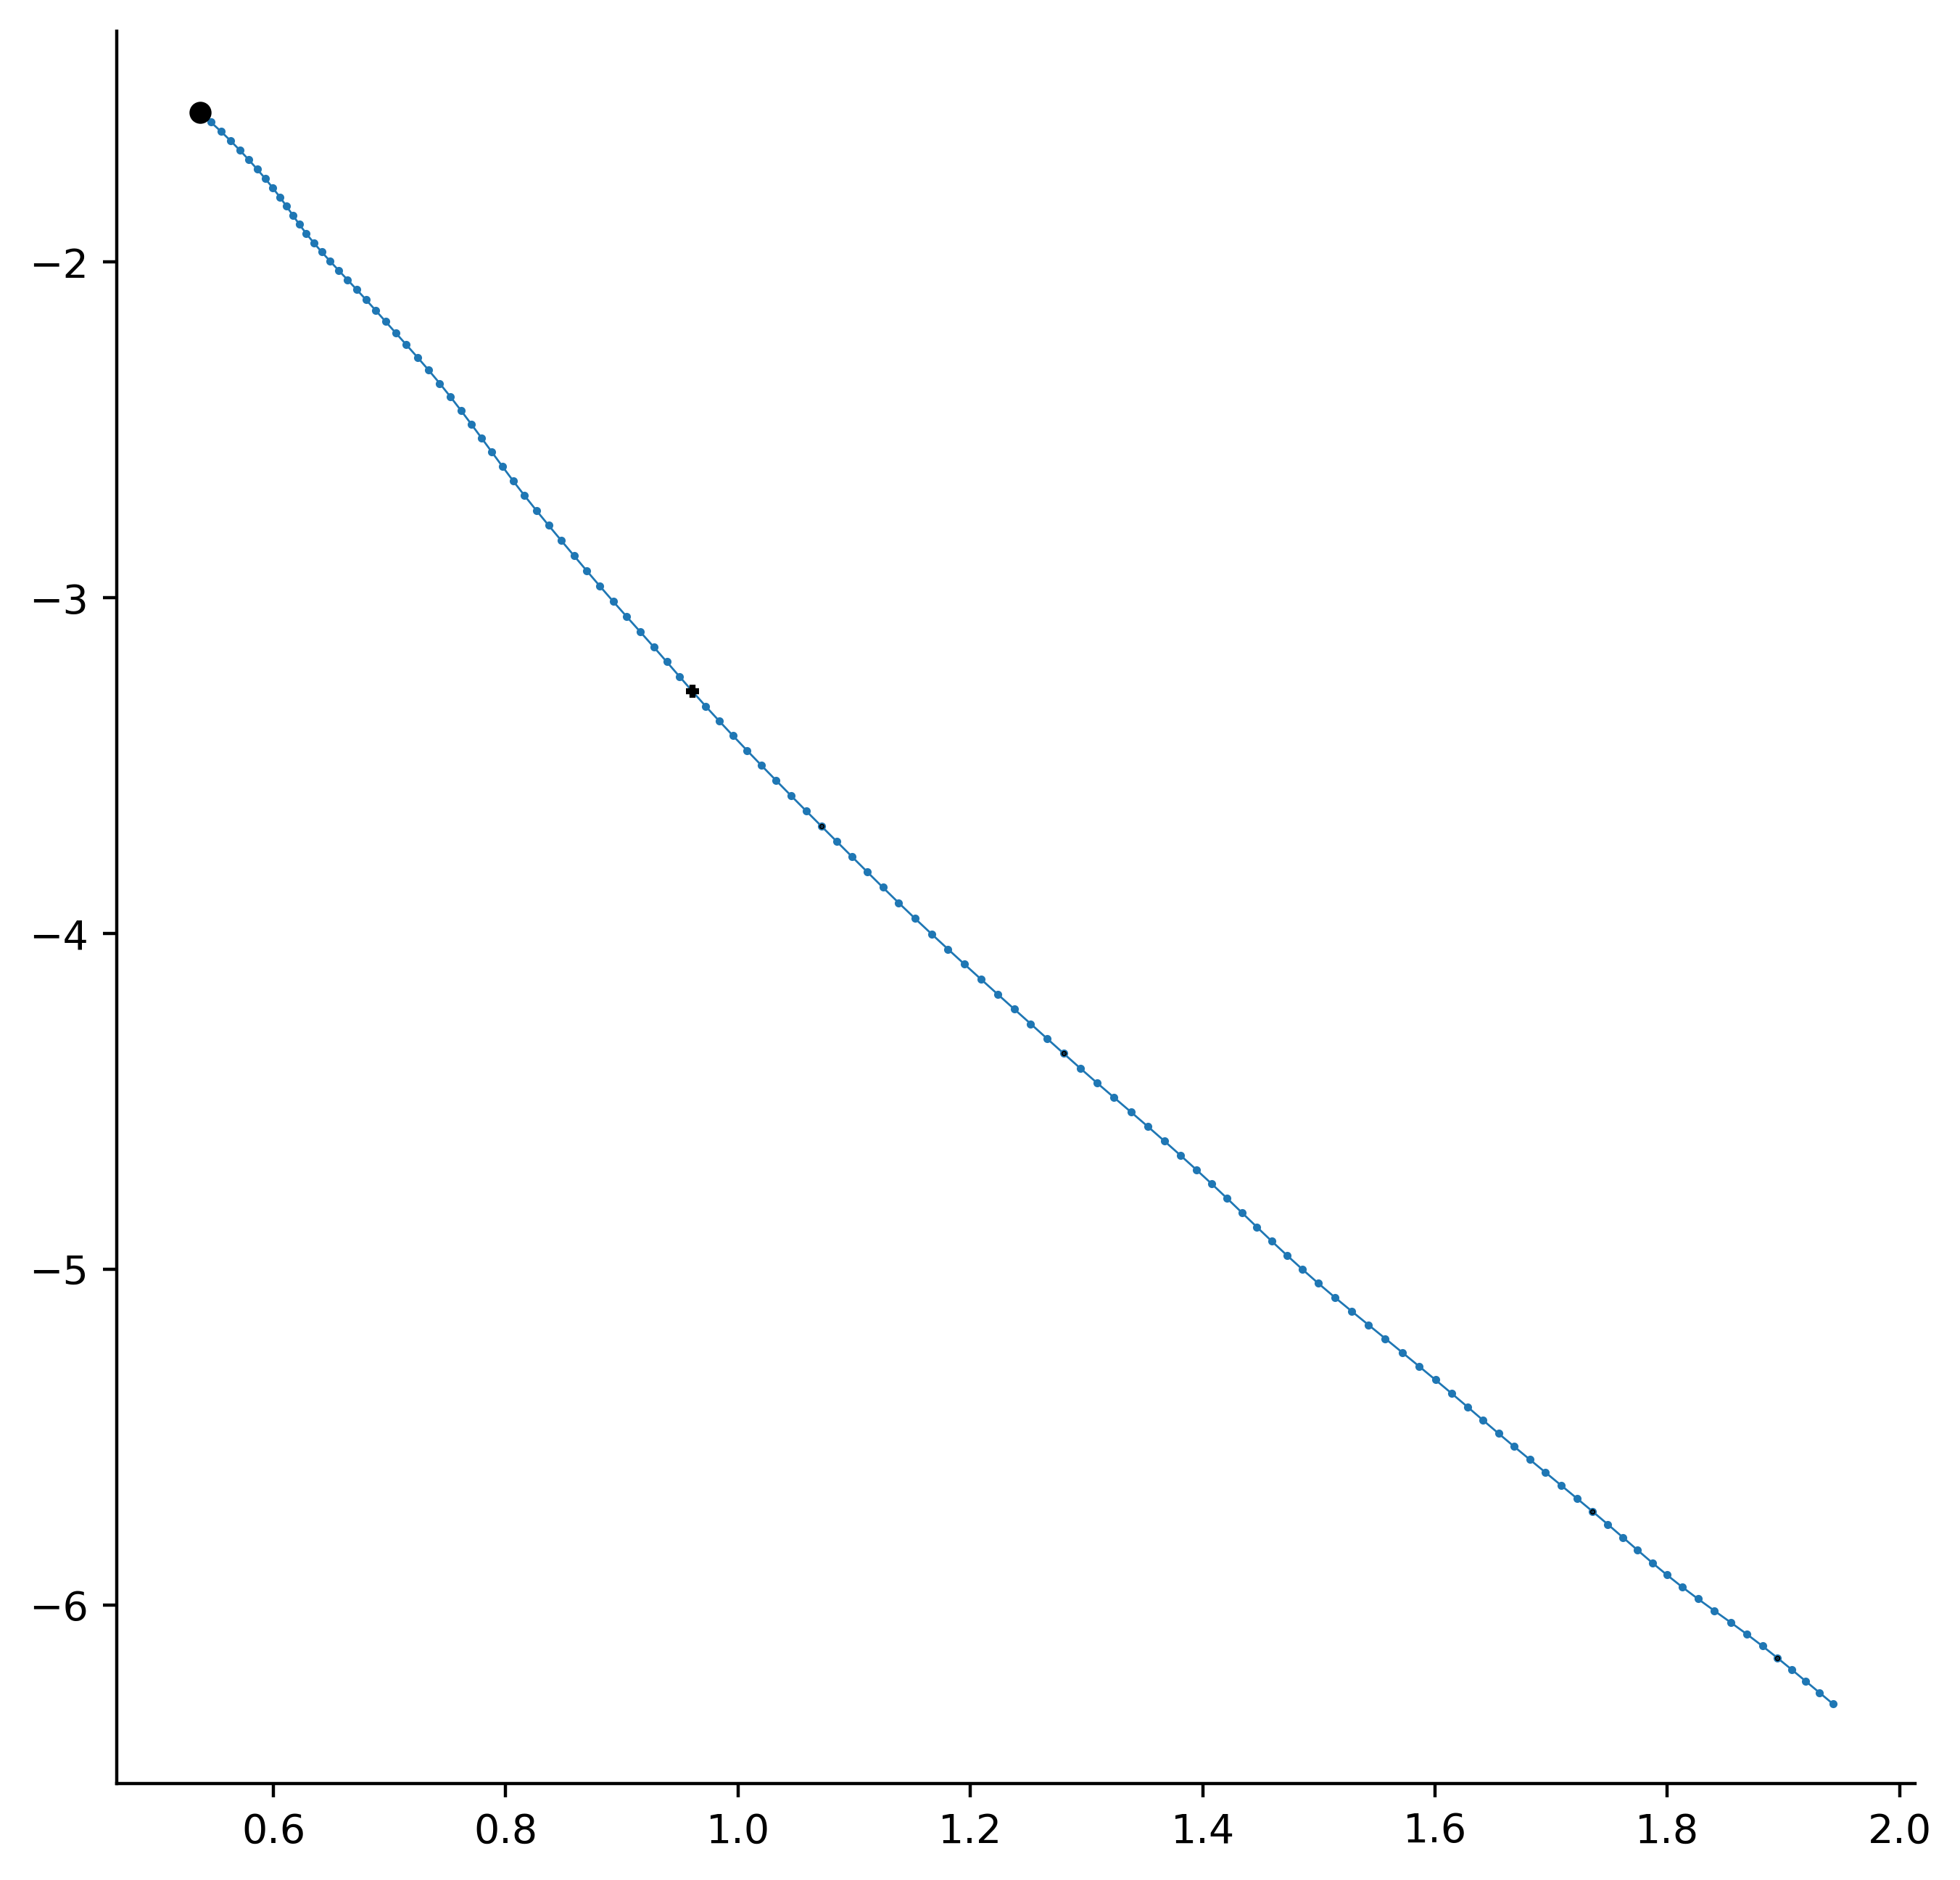

In [118]:
x_ground = choice_new[0][58]
y_ground = intensity_new[0][58]

colors = ['#BF3F00', '#CA5F00', '#D47F00', '#DF9F00', '#EABF00', '#F4DF00', '#FFFF00'][::-1]
colors_m = ['#0542C7', '#1E59BB', '#3770AF', '#5187A3', '#6A9E96', '#83B58A', '#9CCC7E'][::-1]

#plt.figure(figsize=(8,8), dpi=100, frameon=False)
fig, ax = plt.subplots(figsize=(8,8), dpi=400)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
hit_labels = []
miss_labels = []
for i in range(len(choice_new)):
    c = i
    
    diffx = choice_new[i][58] - x_ground
    diffy = intensity_new[i][58] - y_ground
    
    diffx = 0
    diffy = 0
    
    a = sn[i] != 0
    
    plt.scatter(choice_new[c][a][0]-diffx, intensity_new[c][a][0]-diffy, zorder=4, s=10, color='black', marker='+')
    plt.scatter(choice_new[c][a]-diffx, intensity_new[c][a]-diffy, zorder=4, s=.5, color='black', marker='.')
    h, = plt.plot(choice_new[c][58:]-diffx, intensity_new[c][58:]-diffy, marker='o', linewidth=0.5, markersize=1, zorder=1, label='stim #{} hit'.format(i+1))
    hit_labels.append('stim #{} hit'.format(i+1))
    miss_labels.append('stim #{} miss'.format(i+1))
    #plt.scatter(choice[c][58]-diffx, intensity[c][58]-diffy, color='g', s=10, zorder=2)
    #plt.scatter(choice[c][116]-diffx, intensity[c][116]-diffy, color='y', s=10, zorder=2)
    #plt.scatter(choice[c][179]-diffx, intensity[c][179]-diffy, color='r', s=10, zorder=2)
#first_legend = plt.legend(hits[0],['asd', 'as', 'a', 'a', 'a', 'a,', 'a'])
#plt.legend(hits[0] for h in hits)
#plt.gca().add_artist(first_legend)
ax.scatter([x_ground], [y_ground], s=20, color='black', zorder=3)

In [119]:
h = h5py.File('clfs_presence', 'r')
l = h5py.File('clfs_hitmiss', 'r')

with open('filedict.json') as s:
    filedict = json.load(s)

In [120]:
coefs_presence = h[filelist[1]+'_coefs']
coefs_hitmiss = l[filelist[1]+'_coefs']
intercept_presence = h[filelist[1]+'_intercept']
intercept_hitmiss = h[filelist[1]+'_intercept']

In [121]:
#stimulus 3:
w = coefs_hitmiss[5]

In [122]:
w_c = np.dot(b_1, w.T)
w_i = np.dot(b_2, w.T)
b = intercept_hitmiss[5]*b_2[0]

ValueError: shapes (97,) and (96,) not aligned: 97 (dim 0) != 96 (dim 0)

In [ ]:
a = -w_c / w_i
xx = np.linspace(-2,2)
b=0
yy = a * xx #- b / w_i

In [ ]:
plt.plot(xx, yy)

In [78]:
intercept_hitmiss[5]

-0.83358740360758754

In [80]:
b_1[0]

-0.12149898790135927